<a href="https://colab.research.google.com/github/creativitylabb/lstm_prediction/blob/main/lstm_air_quality_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import os
from plotly import graph_objs as go

import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [2]:
def clean_data():
    """
    Read initial df and impute missing values with SimpleImputer
    Remove data before 2021-01-01, as there are too many values missing
    """
    df = pd.read_csv('https://gitlab.com/creativitylabb/data-lstm/-/raw/main/last_step_pagination_110422.csv', infer_datetime_format=True)

    df = df.drop('Unnamed: 0', axis=1)

    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format="%Y-%m-%d %H:%M:%S")

    df.index = df['TimeStamp']
    df.index.sort_values()

    print(df.count())  

    # remove data before 2021
    df = df[df.index > '2021-01-01']

    # add missing days
    df = df.resample('D').mean()


    # check how many rows are missing
    def percentage(part, whole):
        return 100 * float(part) / float(whole)

    row_count = df.shape[0]

    for c in df.columns:
        m_count = df[c].isna().sum()

        if m_count > 0:
            print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

    df = df.drop(['LocationLat', 'LocationLong'], axis=1)


    # add 0 instead of NaN for pm2.5, pm1 and pm10 as their min is around 0
    # zero_columns = ['pm25', 'pm1', 'pm10']
    # for column in zero_columns:
    #     df[column] = df[column].fillna(0)
    # print('columns', df.columns)
    #todo check impute 0 or most frequent values for pm2.5, pm1 and pm10


    #impute missing data with simple imputer
    sensor_column_names = ['pm25', 'pm1', 'pm10', 'co2', 'o3', 'cho2', 'no2', 'so2']
    imp = SimpleImputer(strategy="most_frequent")
    df_mean_imputed = pd.DataFrame(imp.fit_transform(df.iloc[:, 0:]), columns=sensor_column_names)
    
    df_mean_imputed['TimeStamp'] = df.index
    df_mean_imputed.index = df.index

    df_mean_imputed['TimeStamp'] = df.index
    df_mean_imputed.index = df.index

    #save new data to df
    df_mean_imputed.to_csv('df_imputed_120422.csv')  
    return df_mean_imputed

In [3]:
df=clean_data() #impute data

TimeStamp       435
pm25            435
pm1             435
pm10            435
co2             425
o3              426
cho2            425
no2             424
so2             367
LocationLat     435
LocationLong    435
dtype: int64
pm25 - 33 (7.143%) rows missing
pm1 - 33 (7.143%) rows missing
pm10 - 33 (7.143%) rows missing
co2 - 39 (8.442%) rows missing
o3 - 38 (8.225%) rows missing
cho2 - 39 (8.442%) rows missing
no2 - 38 (8.225%) rows missing
so2 - 95 (20.563%) rows missing
LocationLat - 33 (7.143%) rows missing
LocationLong - 33 (7.143%) rows missing


In [4]:
df #imputed df

,pm25,pm1,pm10,co2,o3,cho2,no2,so2,TimeStamp
TimeStamp,,,,,,,,,
2021-01-09,10.000000,3.000000,3.000000,433.508333,27.316667,6.8,6.280000,2.401389,2021-01-09
2021-01-10,1.000000,6.450079,6.000000,433.508333,27.316667,6.8,6.280000,2.401389,2021-01-10
2021-01-11,1.000000,1.000000,1.000000,433.508333,27.316667,6.8,6.280000,2.401389,2021-01-11
2021-01-12,1.000000,6.450079,6.000000,433.508333,27.316667,6.8,6.280000,2.401389,2021-01-12
2021-01-13,1.000000,6.450079,6.000000,433.508333,27.316667,6.8,6.280000,2.401389,2021-01-13
...,...,...,...,...,...,...,...,...,...
2022-04-11,12.367347,7.224490,12.067797,618.400000,32.828571,6.6,11.630000,2.366667,2022-04-11
2022-04-12,1.000000,6.450079,6.000000,433.508333,27.316667,6.8,6.280000,2.401389,2022-04-12
2022-04-13,1.000000,6.450079,6.000000,433.508333,27.316667,6.8,6.280000,2.401389,2022-04-13


In [5]:
#plot loss and val_loss
def plot_loss(history,epochs):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  no_epochs = range(epochs)
  plt.plot(no_epochs, loss_train, 'g', label='Training loss')
  plt.plot(no_epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#plot accuracy and val_accuracy
def plot_accuracy(history,epochs):
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  no_epochs = range(epochs)
  plt.plot(no_epochs, acc_train, 'g', label='Training accuracy')
  plt.plot(no_epochs, acc_val, 'b', label='validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [6]:
def create_model_lstm(df, column_index, sensor_name, epochs):
    """Create LSTM multivariate model, choose parameters, fit model, save model to file"""
    scaler = MinMaxScaler()  # scale data
    data_scaled = scaler.fit_transform(df)

    features = data_scaled  # pm25 pm1	pm10
    target = data_scaled[:, column_index]  # target sensor to be predicted

    # target = data_scaled[:, 0]  # pm25
    # target = data_scaled[:, 1]  # pm1
    # target = data_scaled[:, 2]  # pm10

    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123,
                                                        shuffle=False)
    df.index = pd.to_datetime(df.index)

    win_length = 2
    batch_size = 128

    num_features = len(df.columns)  # features used in model

    train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

    ################################
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(150, input_shape=(win_length, num_features), return_sequences=True))

    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.LSTM(50, return_sequences=True))

    model.add(tf.keras.layers.Dropout(0.2))  # make sure not overfit
    model.add(tf.keras.layers.LSTM(60, return_sequences=False))

    model.add(tf.keras.layers.Dense(1))

    print(model.summary())

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=["accuracy"])

    history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, shuffle=False)

    plot_loss(history, epochs)

    plot_accuracy(history, epochs)

    model.evaluate_generator(test_generator, verbose=0)  # evaluate model with test data

    model.save('lstm_model_' + str(sensor_name) + '.h5')  # creates a HDF5 file


In [7]:
#prepare data for forecast
df.index = df['TimeStamp']
df = df.drop('TimeStamp', axis=1)

#get only pm2.5, pm1 and pm10 as these sensors are related
df = df[['pm25', 'pm1', 'pm10']]

In [8]:
df

,pm25,pm1,pm10
TimeStamp,,,
2021-01-09,10.000000,3.000000,3.000000
2021-01-10,1.000000,6.450079,6.000000
2021-01-11,1.000000,1.000000,1.000000
2021-01-12,1.000000,6.450079,6.000000
2021-01-13,1.000000,6.450079,6.000000
...,...,...,...
2022-04-11,12.367347,7.224490,12.067797
2022-04-12,1.000000,6.450079,6.000000
2022-04-13,1.000000,6.450079,6.000000


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 150)            92400     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             40200     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 60)                26640     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 159,301
Trainable params: 159,301
Non-trai

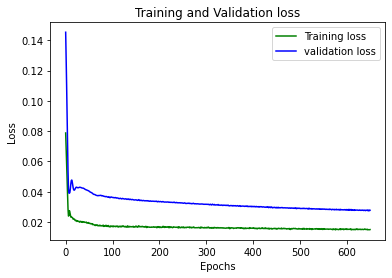

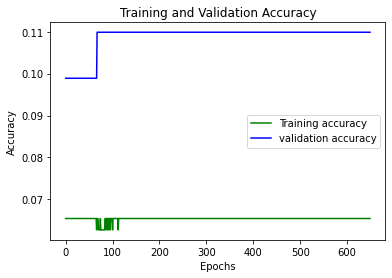

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


In [9]:
create_model_lstm(df=df, column_index=0, sensor_name='pm25',epochs=650) #create pm2.5 model based on pm1 and pm10


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 2, 150)            92400     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 150)            0         
                                                                 
 lstm_4 (LSTM)               (None, 2, 50)             40200     
                                                                 
 dropout_1 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                26640     
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 159,301
Trainable params: 159,301
Non-tr

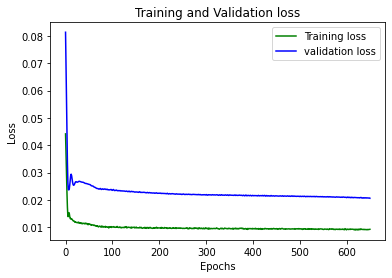

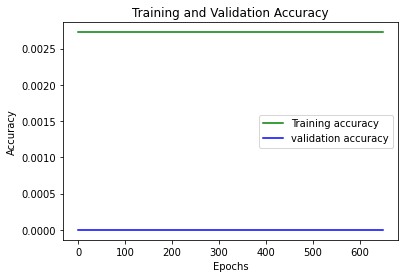

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


In [10]:
create_model_lstm(df=df, column_index=1, sensor_name='pm1',epochs=650) #create pm1 model based on pm2.5 and pm10


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 150)            92400     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2, 150)            0         
                                                                 
 lstm_7 (LSTM)               (None, 2, 50)             40200     
                                                                 
 dropout_2 (Dropout)         (None, 2, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 60)                26640     
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 159,301
Trainable params: 159,301
Non-tr

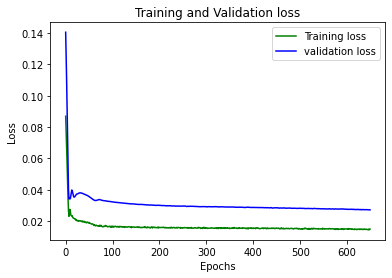

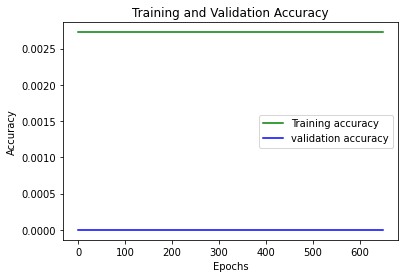

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


In [11]:
create_model_lstm(df=df, column_index=2, sensor_name='pm10',epochs=650) #create pm10 model based on pm2.5 and pm10

In [12]:
def plot_fb_data(result, y, yhat, ds):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result[ds], y=result[y], name=y))
    fig.add_trace(go.Scatter(x=result[ds], y=result[yhat], name=yhat))
    fig.layout.update(title_text='Predicted vs Actual Observations', xaxis_rangeslider_visible=False)
    fig.show()

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import load_model


In [14]:
def load_model_lstm(df,selected_sensor):
    #load created model

  if selected_sensor == 'pm25':
      model = load_model('lstm_model_pm25.h5') #used to forecast pm2.5, based on pm2.5, pm1 and pm10
  elif selected_sensor == 'pm1':
      model = load_model('lstm_model_pm1.h5')
  elif selected_sensor == 'pm10':
      model = load_model('lstm_model_pm10.h5')


  df = df[['pm25', 'pm1', 'pm10']]

  scaler = MinMaxScaler()
  data_scaled = scaler.fit_transform(df)

  features = data_scaled  
  if selected_sensor == 'pm25':
      target = data_scaled[:, 0]  # pm25 
  elif selected_sensor == 'pm1':
      target = data_scaled[:, 1]  # pm1
  elif selected_sensor == 'pm10':
      target = data_scaled[:, 2]  # pm10 

  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123,
                                                      shuffle=False)  
  win_length = 2 
  batch_size = 128  
  test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1,
                                      batch_size=batch_size)

  predictions = model.predict_generator(test_generator)

  df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)

  rev_trans = scaler.inverse_transform(df_pred) #invert the scaling

  df_final = df[predictions.shape[0] * -1:]

  df_final['predicted ' + str(selected_sensor)] = rev_trans[:,
                                                  0]  # get only first column, pm10 predicted column


  df_final['TimeStamp'] = df_final.index


  print("DF FINAL\n ", df_final)

  plot_fb_data(df_final, selected_sensor, 'predicted ' + str(selected_sensor), 'TimeStamp')

  df_final['predicted-actual'] = df_final['predicted ' + str(selected_sensor)] - df_final[selected_sensor]

  mse = mean_squared_error(df_final[selected_sensor], df_final['predicted ' + str(selected_sensor)])  # not future
  r2 = r2_score(df_final[selected_sensor], df_final['predicted ' + str(selected_sensor)])
  mae = mean_absolute_error(df_final[selected_sensor], df_final['predicted ' + str(selected_sensor)])
  rmse = mean_squared_error(df_final[selected_sensor], df_final['predicted ' + str(selected_sensor)], squared=False)

  print("MSE ", mse)
  print("RMSE ", rmse)
  print("R2 ", r2)
  print("MAE ", mae)
  print("RMSE/MAE", rmse / mae)

In [15]:
load_model_lstm(df,'pm25') #predict pm2.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


DF FINAL
                   pm25        pm1       pm10  predicted pm25  TimeStamp
TimeStamp                                                             
2022-01-15  14.515510   8.202363  15.942284       19.906297 2022-01-15
2022-01-16  26.439210  15.942249  28.780206       14.397730 2022-01-16
2022-01-17  19.188465   9.050772  24.675833       24.837341 2022-01-17
2022-01-18  11.376648   6.633710  11.898477       18.906362 2022-01-18
2022-01-19  23.786174  14.188103  25.068641       12.209269 2022-01-19
...               ...        ...        ...             ...        ...
2022-04-11  12.367347   7.224490  12.067797        9.710139 2022-04-11
2022-04-12   1.000000   6.450079   6.000000       12.088938 2022-04-12
2022-04-13   1.000000   6.450079   6.000000        3.587144 2022-04-13
2022-04-14   1.000000   6.450079   6.000000        6.917750 2022-04-14
2022-04-15  16.520000  10.386667  17.133333        6.917750 2022-04-15

[91 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MSE  87.28698760866058
RMSE  9.342750537644713
R2  0.34929800924477616
MAE  7.051441206382889
RMSE/MAE 1.3249419890486722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
load_model_lstm(df,'pm1') #predict pm1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



DF FINAL
                   pm25        pm1       pm10  predicted pm1  TimeStamp
TimeStamp                                                            
2022-01-15  14.515510   8.202363  15.942284      14.881352 2022-01-15
2022-01-16  26.439210  15.942249  28.780206      10.760544 2022-01-16
2022-01-17  19.188465   9.050772  24.675833      17.203823 2022-01-17
2022-01-18  11.376648   6.633710  11.898477      13.290578 2022-01-18
2022-01-19  23.786174  14.188103  25.068641       8.854147 2022-01-19
...               ...        ...        ...            ...        ...
2022-04-11  12.367347   7.224490  12.067797       8.714169 2022-04-11
2022-04-12   1.000000   6.450079   6.000000       8.785901 2022-04-12
2022-04-13   1.000000   6.450079   6.000000       6.728949 2022-04-13
2022-04-14   1.000000   6.450079   6.000000       9.777464 2022-04-14
2022-04-15  16.520000  10.386667  17.133333       9.777465 2022-04-15

[91 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MSE  48.81849336027544
RMSE  6.987023211659987
R2  0.1098009069365189
MAE  4.976232460976947
RMSE/MAE 1.4040789425436682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
load_model_lstm(df,'pm10') #predict pm10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



DF FINAL
                   pm25        pm1       pm10  predicted pm10  TimeStamp
TimeStamp                                                             
2022-01-15  14.515510   8.202363  15.942284       20.068984 2022-01-15
2022-01-16  26.439210  15.942249  28.780206       14.282411 2022-01-16
2022-01-17  19.188465   9.050772  24.675833       24.039547 2022-01-17
2022-01-18  11.376648   6.633710  11.898477       19.553124 2022-01-18
2022-01-19  23.786174  14.188103  25.068641       11.946885 2022-01-19
...               ...        ...        ...             ...        ...
2022-04-11  12.367347   7.224490  12.067797       10.136900 2022-04-11
2022-04-12   1.000000   6.450079   6.000000       12.150795 2022-04-12
2022-04-13   1.000000   6.450079   6.000000        6.384995 2022-04-13
2022-04-14   1.000000   6.450079   6.000000        9.500606 2022-04-14
2022-04-15  16.520000  10.386667  17.133333        9.500607 2022-04-15

[91 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MSE  128.5326248551943
RMSE  11.337222978101574
R2  0.15938614544560326
MAE  8.31364318188624
RMSE/MAE 1.3636889063032085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

